In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
sys.path.append('../../03b_model/src')
from LSTMDA_torch import LSTMDA, fit_torch_model, rmse_masked
import seaborn as sns
import torch
#import run_model
import yaml
import matplotlib.pyplot as plt

In [3]:
#read prepped data in
prepped_model_io_data_file = '../out/prepped_model_io_data'
with open(prepped_model_io_data_file, 'rb') as f:
    prepped_model_io_data = pickle.load(f)

In [4]:
config

Available objects for config:
     AliasManager
     DisplayFormatter
     HistoryManager
     IPCompleter
     IPKernelApp
     InlineBackend
     LoggingMagics
     MagicsManager
     OSMagics
     PrefilterManager
     ScriptMagics
     StoreMagics
     ZMQInteractiveShell


In [5]:
#set parameters using config file
with open("../model_config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

#x variables
inputs = config['inputs']
#model target
target = config['target']

#other params from config file
seq_len = config['seq_len']
offset = config['offset']
n_epochs = config['n_epochs']
hidden_units = config['hidden_units']
learn_rate = config['learn_rate']
recur_dropout = config['recur_dropout']
dropout = config['dropout']

n_batch, seq_len, n_feat  = prepped_model_io_data['trainval_features'].shape

In [6]:
prepped_model_io_data['train_features'].shape

torch.Size([20, 180, 10])

In [7]:
model = LSTMDA(n_feat, hidden_units, recur_dropout, dropout)

model.load_state_dict(torch.load('../out/Run_XAI_test_01/weights.pt')) # ensure that dropout layers are active

x = prepped_model_io_data['trainval_features']
y_pred, _ = model(x)
y = prepped_model_io_data['trainval_targets']

In [9]:
model, y_pred.shape, x.shape

(LSTMDA(
   (dropout): Dropout(p=0.1, inplace=False)
   (recur_dropout): Dropout(p=0.0, inplace=False)
   (dense): Linear(in_features=10, out_features=1, bias=True)
 ),
 torch.Size([30, 180, 1]),
 torch.Size([30, 180, 10]))

In [11]:
def rmse_masked(y_true, y_pred):
    num_y_true = torch.count_nonzero(~torch.isnan(y_true))
    if num_y_true > 0:
        zero_or_error = torch.where(
            torch.isnan(y_true), torch.zeros_like(y_true), y_pred - y_true
        )
        sum_squared_errors = torch.sum(torch.square(zero_or_error))
        rmse_loss = torch.sqrt(sum_squared_errors / num_y_true)
    else:
        rmse_loss = 0.0
    return rmse_loss


def expected_gradients(x, y, x_set, model, n_samples, temporal_focus=None):
    n_series = x_set.shape[0]
    seq_len = x_set.shape[1]
    n_vars = x_set.shape[2]

    for k in range(n_samples):
        # SAMPLE A RANDOM BASELINE INPUT/YEAR
        rand_series = np.random.choice(n_series)
        baseline_x = x_set[rand_series].reshape(1,seq_len,n_vars)
        
        # SAMPLE A RANDOM SCALE ALONG THE DIFFERENCE
        scale = np.random.uniform()

        # SAME IG CALCULATION
        x_diff = x - baseline_x
        curr_x = baseline_x + scale*x_diff
        
        if curr_x.requires_grad == False:
            curr_x.requires_grad = True
        model.zero_grad()
        y,_ = model(curr_x)

        # GET GRADIENT
        if temporal_focus == None:
            gradients = torch.autograd.grad(y[:, :, :], curr_x, torch.ones_like(y[:, :, :]))
        elif temporal_focus != None:
            gradients = torch.autograd.grad(y[:, temporal_focus, :], curr_x, torch.ones_like(y[:, temporal_focus, :]))
        
        if k == 0:
            expected_gradients = x_diff*gradients[0] * 1/n_samples
            
        else:
            expected_gradients = expected_gradients + ((x_diff*gradients[0]) * 1/n_samples)
    return(expected_gradients)


loss_fn = rmse_masked

In [12]:
prepped_model_io_data.keys()

dict_keys(['train_features', 'train_targets', 'val_features', 'val_targets', 'trainval_features', 'trainval_targets', 'test_features', 'test_targets', 'means_stds'])

In [31]:
tq_mean = prepped_model_io_data['means_stds']['x_mean_trnval']['discharge_01463500'].data
tq_sd = prepped_model_io_data['means_stds']['x_std_trnval']['discharge_01463500'].data
sq_mean = prepped_model_io_data['means_stds']['x_mean_trnval']['discharge_01474500'].data
sq_sd = prepped_model_io_data['means_stds']['x_std_trnval']['discharge_01474500'].data
y_mean = prepped_model_io_data['means_stds']['y_mean_trnval']['saltfront_daily'].data
y_std = prepped_model_io_data['means_stds']['y_std_trnval']['saltfront_daily'].data

dates = pd.date_range(start = config['train_start_date'], periods = x.shape[0]*x.shape[1], freq = 'D')
dates = np.array(dates).reshape(y.shape)

tq_original = (x[:,:,0:1]*tq_sd)+tq_mean
y_original = (y*y_std)+y_mean

np.argwhere((y_original.detach().numpy() > 82.9)&(tq_original.detach().numpy()<3000))

array([[  1, 123,   0],
       [  1, 124,   0],
       [  1, 126,   0],
       [  1, 127,   0],
       [  1, 128,   0],
       [  1, 129,   0],
       [  1, 130,   0],
       [  1, 131,   0],
       [  1, 132,   0],
       [  1, 133,   0],
       [  1, 134,   0],
       [  1, 135,   0],
       [  1, 136,   0],
       [  1, 137,   0],
       [  1, 138,   0],
       [  1, 139,   0],
       [  1, 140,   0],
       [  1, 141,   0],
       [  1, 142,   0],
       [  1, 143,   0],
       [  1, 144,   0],
       [  1, 145,   0],
       [  1, 146,   0],
       [  1, 147,   0],
       [  1, 148,   0],
       [  3,  51,   0],
       [  3,  74,   0],
       [  3,  75,   0],
       [  3,  76,   0],
       [  3,  77,   0],
       [  3,  78,   0],
       [  3,  79,   0],
       [  3,  80,   0],
       [  3,  81,   0],
       [  3,  92,   0],
       [  3,  93,   0],
       [  9,  94,   0],
       [  9, 102,   0],
       [  9, 103,   0],
       [  9, 104,   0],
       [  9, 105,   0],
       [  9, 106

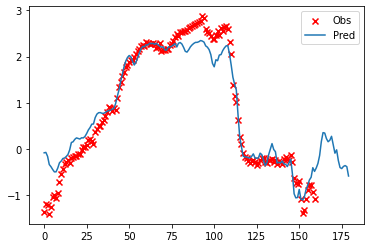

In [11]:
plt.scatter(range(180), y[3, :, 0].detach(), color = 'red', marker = 'x', label = "Obs")
plt.plot(y_pred[3, :,0].detach(), label = 'Pred')
plt.legend();

In [1]:
optimal_input = x.clone()

optimal_input.requires_grad = True
optimizer = torch.optim.Adam([optimal_input], lr = 0.1)
loss_fn = rmse_masked
loss_ls = []


m = torch.nn.ReLU()

for i in range(25):
    
    optimal_output,_ = model(optimal_input)
    loss = loss_fn(y[3,:,:], optimal_output[3, :,:])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_ls.append(loss.item())
    
plt.plot(loss_ls)

NameError: name 'x' is not defined

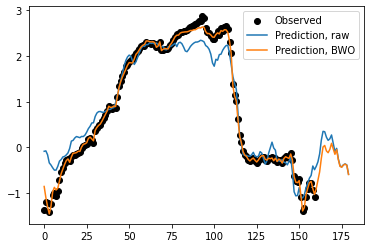

In [13]:
plt.scatter(range(180), y[3].detach(), color = 'black', label = 'Observed')

natural_out, _ = model(x)
plt.plot(natural_out[3].detach(), label = 'Prediction, raw')

optimal_out, _ = model(optimal_input)
plt.plot(optimal_output[3].detach(), label = 'Prediction, BWO')
plt.legend(loc = 'upper right');

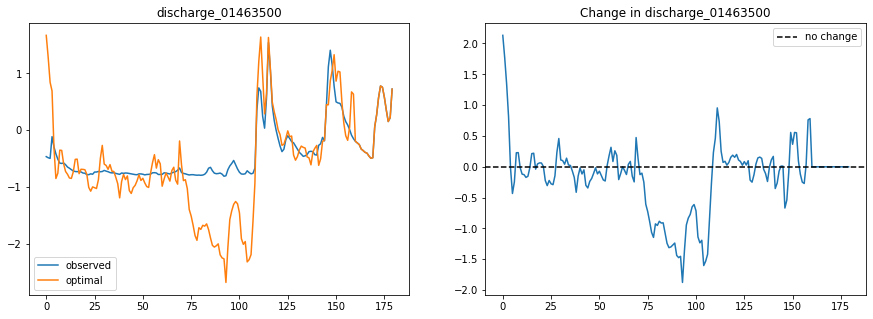

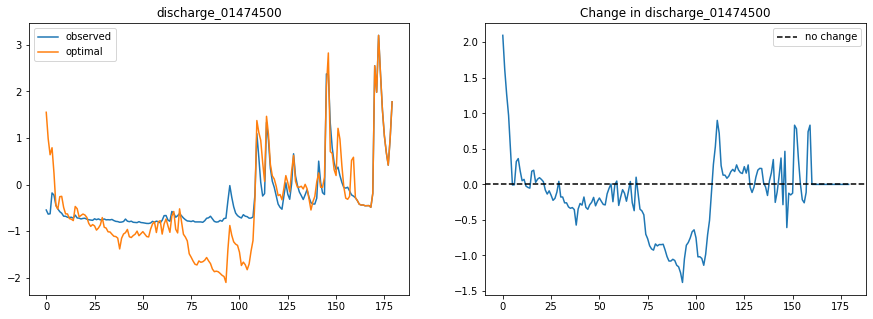

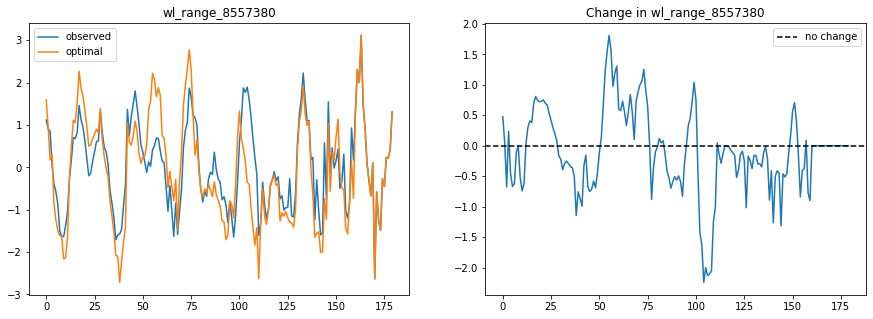

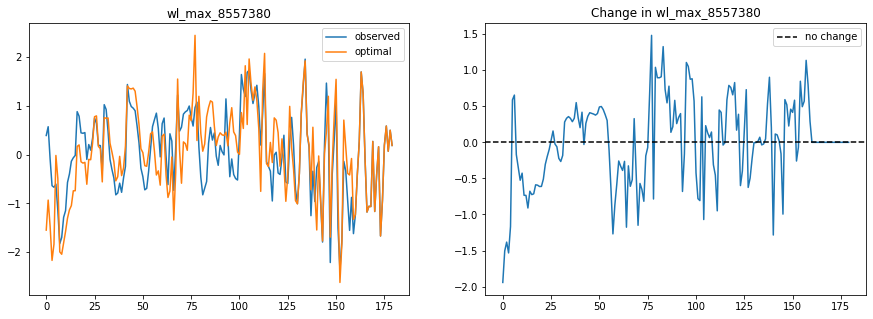

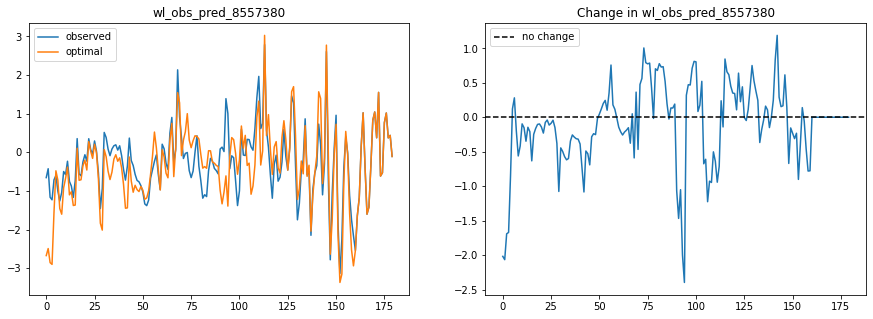

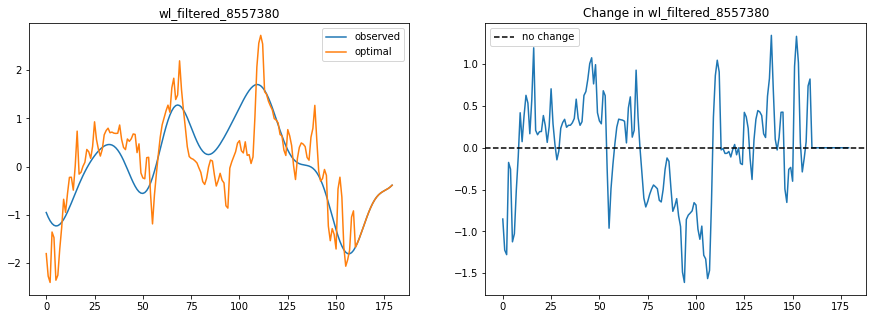

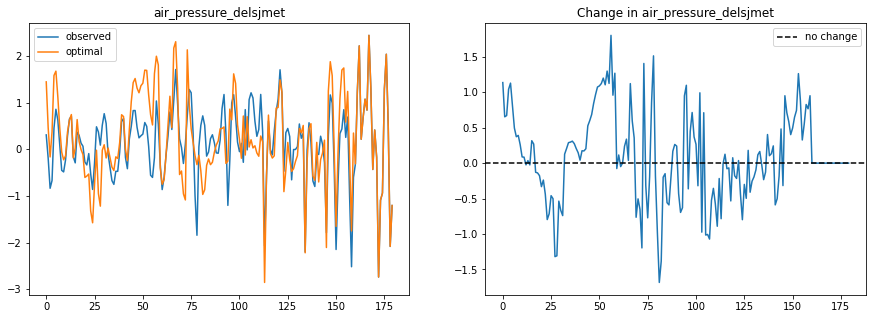

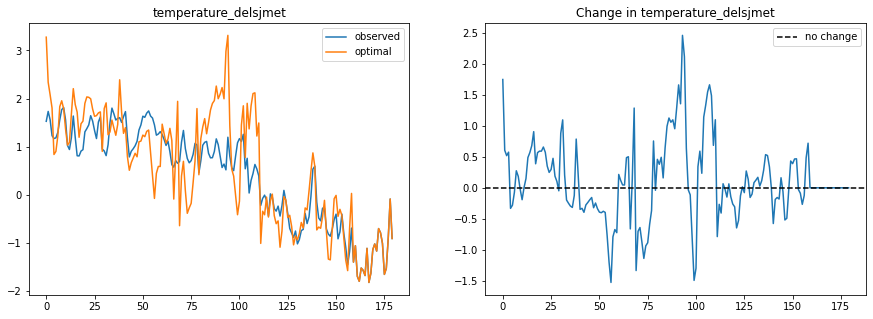

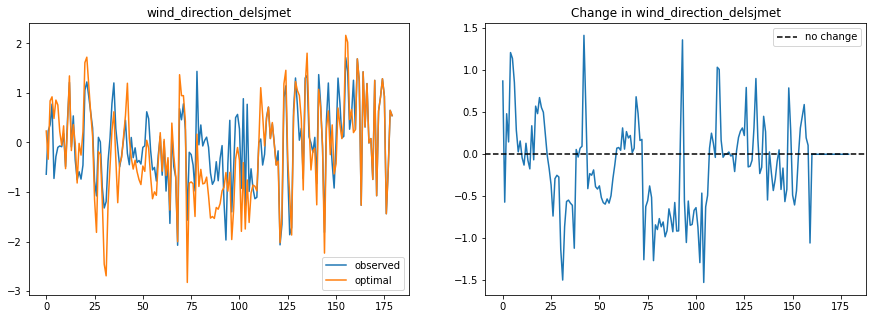

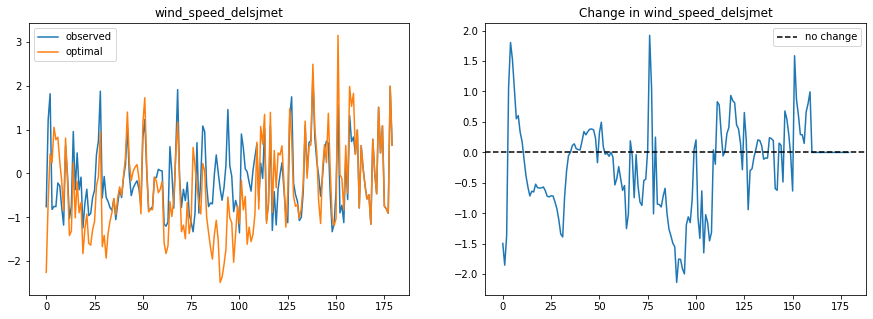

In [14]:
for i in range(10):
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    
    ax[0].plot(range(180), x[3, :, i].detach(), label = 'observed')
    ax[0].plot(range(180), optimal_input[3, :, i].detach(), label = 'optimal')
    ax[0].legend()
    ax[0].set_title(inputs[i])
    
    ax[1].plot(range(180),
               optimal_input[3, :, i].detach() - x[3, :, i].detach())
    ax[1].axhline(0, color = 'black', linestyle = '--', label = 'no change')
    ax[1].legend()
    ax[1].set_title('Change in ' + inputs[i])
    
    plt.pause(0.00001)

In [15]:
# some value setting
# calculate attribution
EG_vals = expected_gradients(x[3].reshape(1,180,10), 
                             y[3].reshape(1,180,1),
                             x, 
                             model=model,
                             n_samples=200, 
                             temporal_focus=93)




discharge_01463500 
	 7.832255e-06
discharge_01474500 
	 4.7164132e-05
wl_range_8557380 
	 2.3876712e-05
wl_max_8557380 
	 2.60884e-05
wl_obs_pred_8557380 
	 0.0001469348
wl_filtered_8557380 
	 0.0002243425
air_pressure_delsjmet 
	 0.00015663447
temperature_delsjmet 
	 4.7343026e-05
wind_direction_delsjmet 
	 5.3536492e-05
wind_speed_delsjmet 
	 0.00016115897


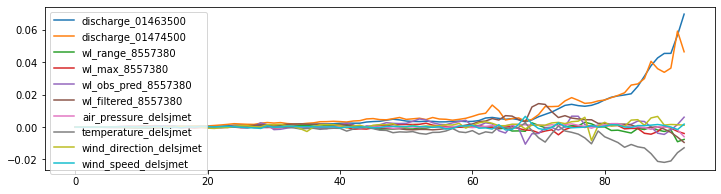

In [16]:
# plot attribution around the extreme space-time
plt.figure(figsize=(12,3))
for i in range(10):
    plt.plot(EG_vals[0,:93, i].detach(), label = inputs[i])
plt.legend(loc='upper left');

# print aggregate measures of attribution
for i in range(10):
    print(inputs[i], '\n\t', np.sum(np.abs(EG_vals[:,:,i].detach().numpy()), axis = 0)[i])

discharge_01463500 
	 8.323439e-05
discharge_01474500 
	 8.859861e-05
wl_range_8557380 
	 4.1379503e-06
wl_max_8557380 
	 4.207708e-05
wl_obs_pred_8557380 
	 0.00011792463
wl_filtered_8557380 
	 0.00019193017
air_pressure_delsjmet 
	 0.00012234735
temperature_delsjmet 
	 2.6683878e-05
wind_direction_delsjmet 
	 4.2133775e-06
wind_speed_delsjmet 
	 5.104338e-05


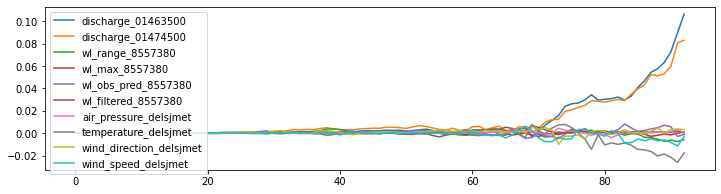

In [17]:
### EGS for optimal inputx
EG_vals = expected_gradients(optimal_input[3].reshape(1,180,10), 
                             y[3].reshape(1,180,1),
                             x, 
                             model=model,
                             n_samples=200, 
                             temporal_focus=93)

plt.figure(figsize=(12,3))
for i in range(10):
    plt.plot(EG_vals[0,:93, i].detach(), label = inputs[i])
plt.legend(loc='upper left');

# print aggregate measures of attribution
for i in range(10):
    print(inputs[i], '\n\t', np.sum(np.abs(EG_vals[:,:,i].detach().numpy()), axis = 0)[i])

In [153]:
prepped_model_io_data.keys()

dict_keys(['train_features', 'train_targets', 'val_features', 'val_targets', 'trainval_features', 'trainval_targets', 'test_features', 'test_targets', 'means_stds'])

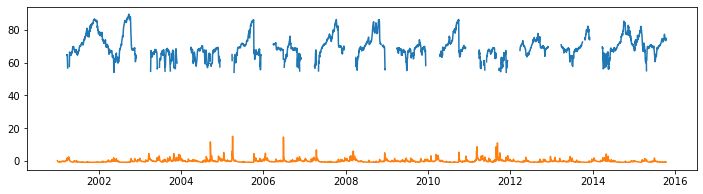

In [28]:
dates = pd.date_range(start = config['train_start_date'], periods = x.shape[0]*x.shape[1], freq = 'D')
plt.figure(figsize=(12,3))
plt.plot(dates, salt_fronts.flatten())
plt.plot(dates, x[:,:,0].flatten())

#### Ok, try to simulate an increasing salt front and see what happens

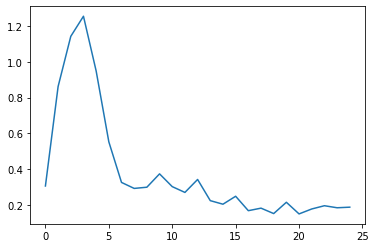

In [197]:
dates = pd.date_range(start = config['train_start_date'], periods = x.shape[0]*x.shape[1], freq = 'D')
dates = np.array(dates).reshape(y.shape)

y_inflated = ((y.clone()*y_std)+y_mean)*1.01
y_inflated = (y_inflated-y_mean)/y_std



optimal_input = x.clone()
optimal_input.requires_grad = True
optimizer = torch.optim.Adam([optimal_input], lr = 0.1)
loss_fn = rmse_masked
loss_ls = []
tq_mean = prepped_model_io_data['means_stds']['x_mean_trnval']['discharge_01463500'].data
tq_sd = prepped_model_io_data['means_stds']['x_std_trnval']['discharge_01463500'].data

m = torch.nn.ReLU()


for i in range(25):
    
    optimal_output,_ = model(optimal_input)
    loss = (loss_fn(y_inflated[1:4], optimal_output[1:4]) + 
            #Penalize discharge for going below zero
            .5*torch.mean(torch.sqrt(m(torch.negative((optimal_input[1:4,:,0]*torch.tensor(tq_sd))+torch.tensor(tq_mean))))) +
            .5*torch.mean(torch.sqrt(m(torch.negative((optimal_input[1:4,:,1]*torch.tensor(tq_sd_s))+torch.tensor(tq_mean_s))))))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_ls.append(loss.item())
    
plt.plot(loss_ls)

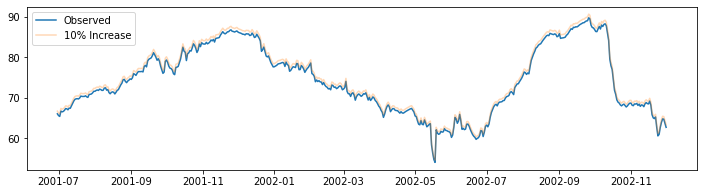

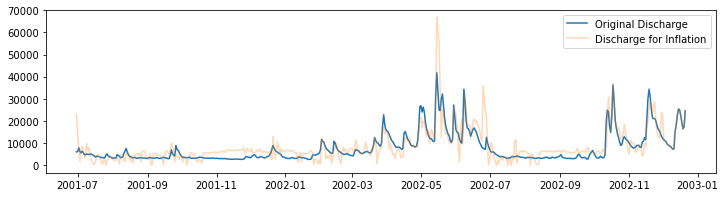

In [198]:
plt.figure(figsize=(12,3))
plt.plot(dates[1:4].flatten(),(y[1:4].flatten().detach().numpy()*y_std)+y_mean,label="Observed")
plt.plot(dates[1:4].flatten(),(y_inflated[1:4].flatten().detach().numpy()*y_std)+y_mean,label='10% Increase',alpha=.3)
plt.legend()
plt.pause(.0001)
plt.figure(figsize=(12,3))
plt.plot(dates[1:4].flatten(),((x[1:4,:,0]*tq_sd)+tq_mean).flatten().detach().numpy(),label='Original Discharge')
plt.plot(dates[1:4].flatten(),((optimal_input[1:4,:,0].detach().numpy()*tq_sd)+tq_mean).flatten(),label='Discharge for Inflation',alpha=.3)
plt.legend()           

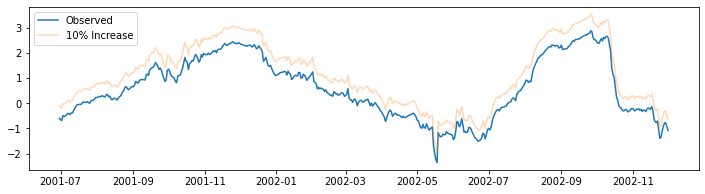

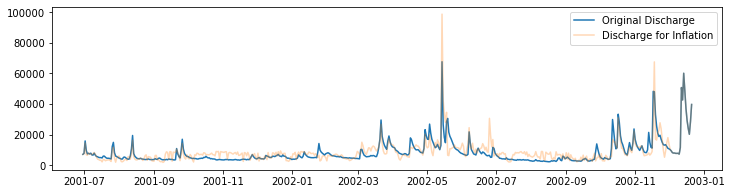

In [190]:
plt.figure(figsize=(12,3))
plt.plot(dates[1:4].flatten(),y[1:4].flatten().detach().numpy(),label="Observed")
plt.plot(dates[1:4].flatten(),y_inflated[1:4].flatten().detach().numpy(),label='10% Increase',alpha=.3)
plt.legend()
plt.pause(.0001)
plt.figure(figsize=(12,3))
plt.plot(dates[1:4].flatten(),((x[1:4,:,1]*tq_sd)+tq_mean).flatten().detach().numpy(),label='Original Discharge')
plt.plot(dates[1:4].flatten(),((optimal_input[1:4,:,1].detach().numpy()*tq_sd)+tq_mean).flatten(),label='Discharge for Inflation',alpha=.3)
plt.legend()        

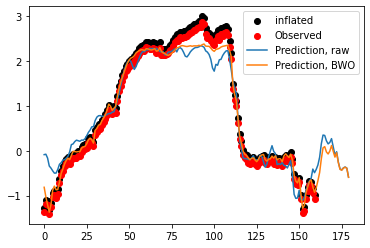

In [200]:
plt.scatter(range(180), y_inflated[3].detach(), color = 'black', label = 'inflated')
plt.scatter(range(180), y[3].detach(), color = 'red', label = 'Observed')
natural_out, _ = model(x)
plt.plot(natural_out[3].detach(), label = 'Prediction, raw')

optimal_out, _ = model(optimal_input)
plt.plot(optimal_output[3].detach(), label = 'Prediction, BWO')
plt.legend(loc = 'upper right');

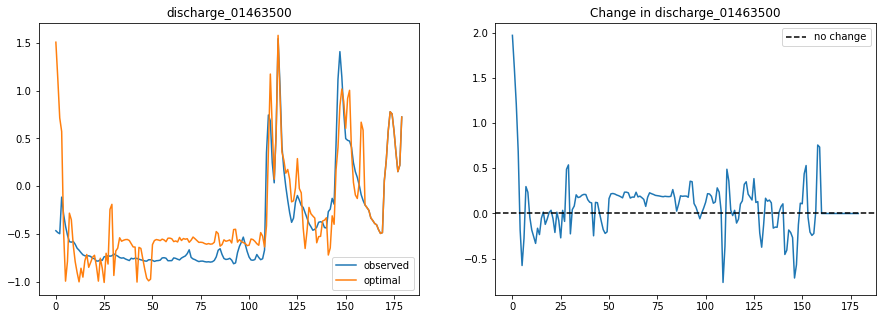

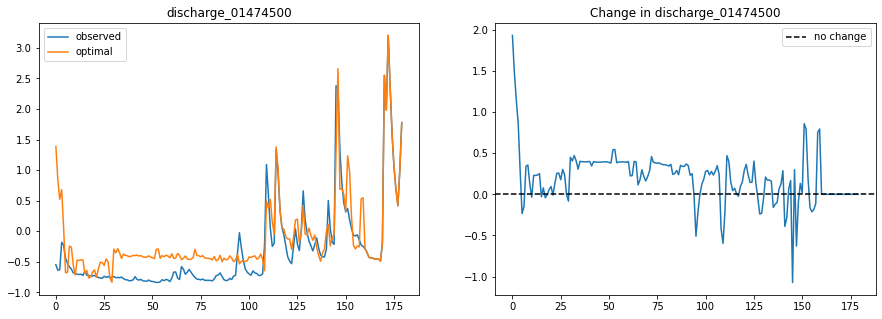

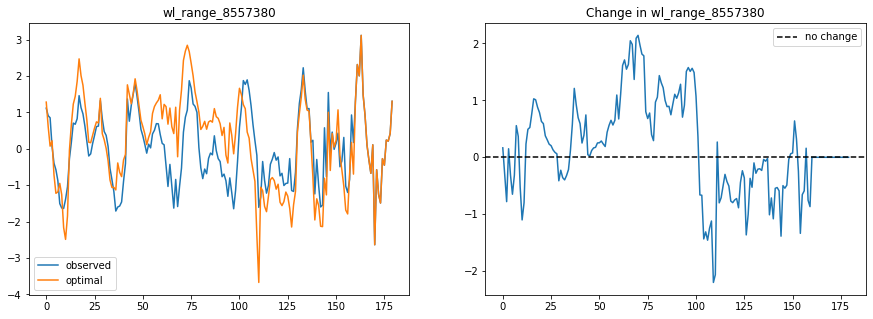

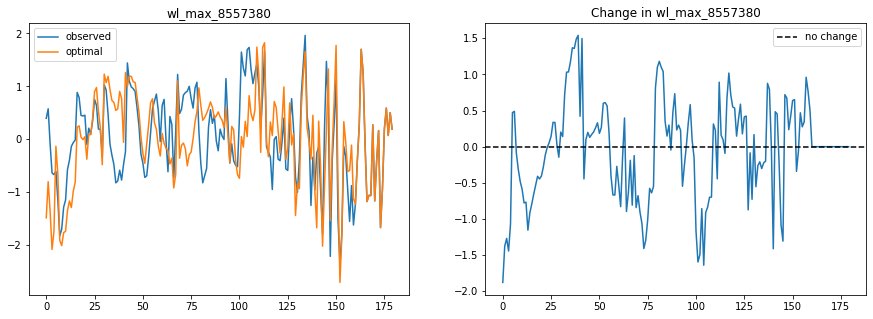

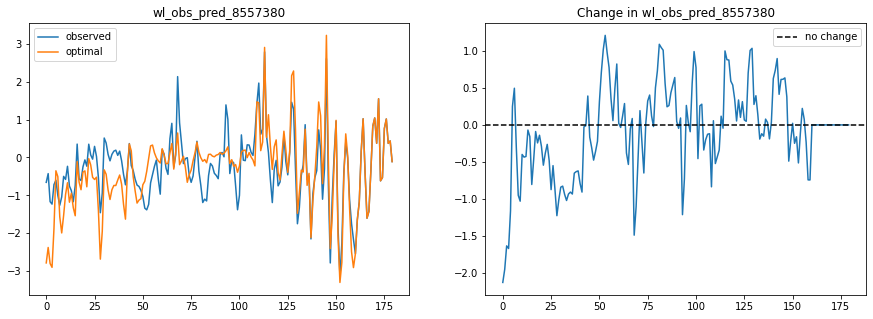

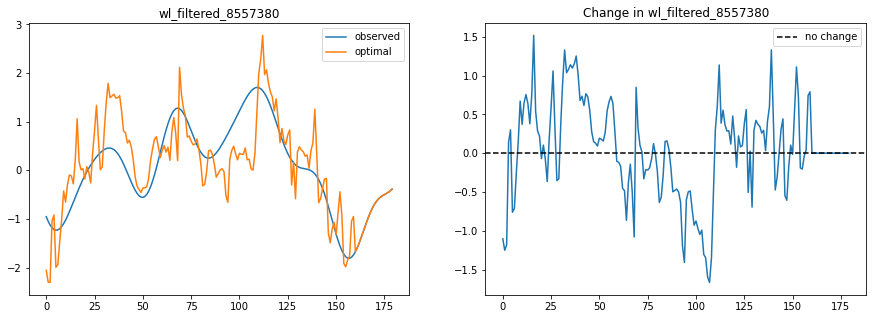

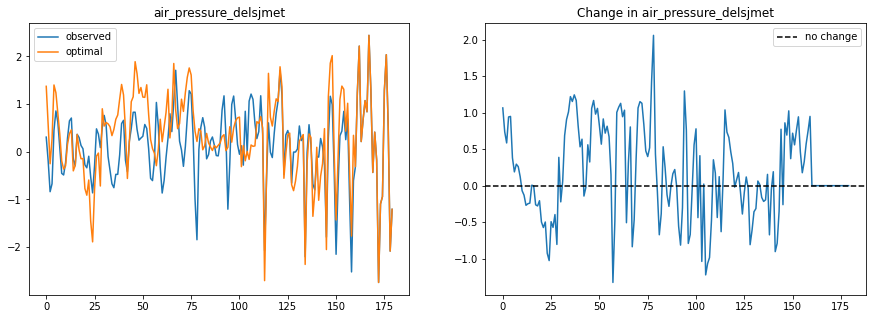

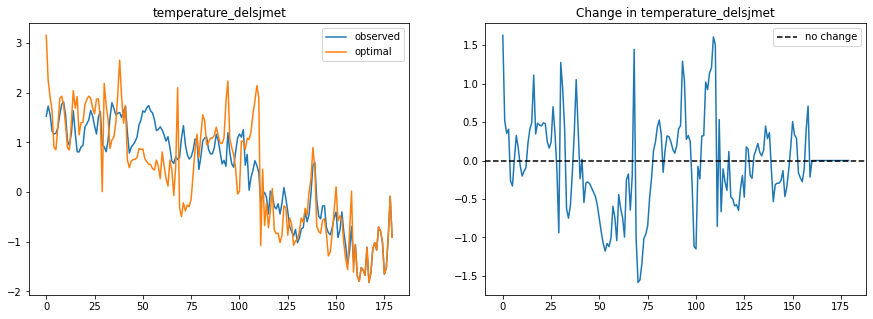

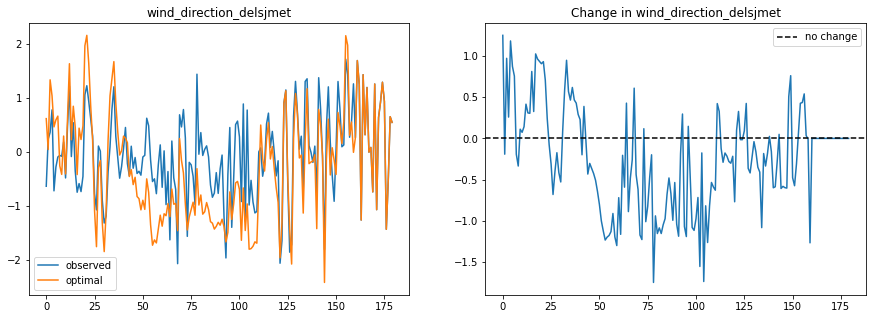

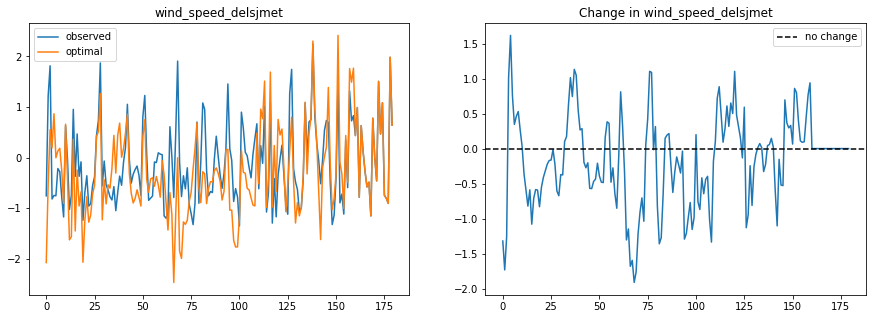

In [201]:
for i in range(10):
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    
    ax[0].plot(range(180), x[3, :, i].detach(), label = 'observed')
    ax[0].plot(range(180), optimal_input[3, :, i].detach(), label = 'optimal')
    ax[0].legend()
    ax[0].set_title(inputs[i])
    
    ax[1].plot(range(180),
               optimal_input[3, :, i].detach() - x[3, :, i].detach())
    ax[1].axhline(0, color = 'black', linestyle = '--', label = 'no change')
    ax[1].legend()
    ax[1].set_title('Change in ' + inputs[i])
    
    plt.pause(0.00001)

## Wrap it into a function and gradually increase 

In [61]:
y_mean = prepped_model_io_data['means_stds']['y_mean_trnval']['saltfront_daily'].data
y_std = prepped_model_io_data['means_stds']['y_std_trnval']['saltfront_daily'].data
tq_mean = prepped_model_io_data['means_stds']['x_mean_trnval']['discharge_01463500'].data
tq_sd = prepped_model_io_data['means_stds']['x_std_trnval']['discharge_01463500'].data
tq_mean_s = prepped_model_io_data['means_stds']['x_mean_trnval']['discharge_01474500'].data
tq_sd_s = prepped_model_io_data['means_stds']['x_std_trnval']['discharge_01474500'].data


def adjust_front(x_set, y_set, target_series, start, stop, step):
    loss_fn = rmse_masked
    inputs_out = []
    output_out = []
    y_out= []
    for i in np.arange(start,stop,step):
        y_inflated = ((y_set.clone()*y_std)+y_mean)*i
        y_inflated = (y_inflated-y_mean)/y_std
        loss_mask = torch.where(y_inflated>2)
        optimal_input = x_set.clone()
        optimal_input.requires_grad = True
        optimizer = torch.optim.Adam([optimal_input], lr = 0.01)
        
        m = torch.nn.ReLU()
        loss_ls=[]
        
        for i in range(50):

            optimal_output,_ = model(optimal_input)
            loss = (loss_fn(y_inflated[target_series], optimal_output[target_series]) + 
                    #Penalize discharge for going below zero
                    .001*torch.mean(torch.sqrt(m(torch.negative((optimal_input[target_series,:,0]*torch.tensor(tq_sd))+torch.tensor(tq_mean))))) +
                    .001*torch.mean(torch.sqrt(m(torch.negative((optimal_input[target_series,:,1]*torch.tensor(tq_sd_s))+torch.tensor(tq_mean_s))))))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_ls.append(loss.item())
        
        plt.plot(loss_ls)
        opt_out,_=model(optimal_input)
        y_out.append(y_inflated.detach().numpy())
        output_out.append(opt_out.detach().numpy())
        inputs_out.append(optimal_input.detach().numpy())
    return {'optimal_inputs':np.array(inputs_out), 'optimal_outputs':np.array(output_out), 'y_out':np.array(y_out)}


((6, 30, 180, 10), (6, 30, 180, 1))

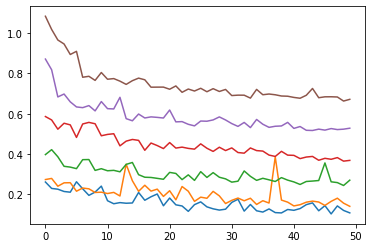

In [62]:
fronts = adjust_front(x, y, slice(1,2),1,1.1,0.02)
fronts['optimal_inputs'].shape, fronts['optimal_outputs'].shape

In [355]:
opt_inputs = fronts['optimal_inputs']
ops_outputs = fronts['optimal_outputs']
inputs_scaled = np.ones_like(opt_inputs)
for i in range(10):
    inputs_scaled[:,:,:,i] = ((opt_inputs[:,:,:,i]*prepped_model_io_data['means_stds']['x_std_trnval'][config['inputs'][i]].data) +
                              prepped_model_io_data['means_stds']['x_mean_trnval'][config['inputs'][i]].data)
outputs_scaled = (ops_outputs*y_std)+y_mean
y_out_scaled = (fronts['y_out']*y_std)+y_mean

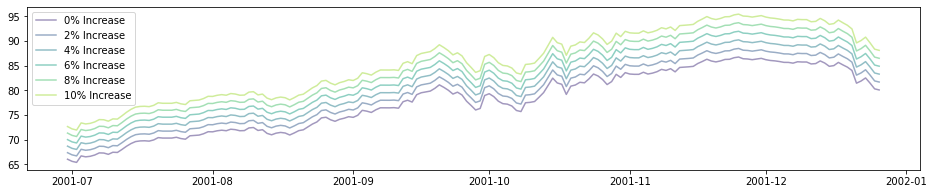

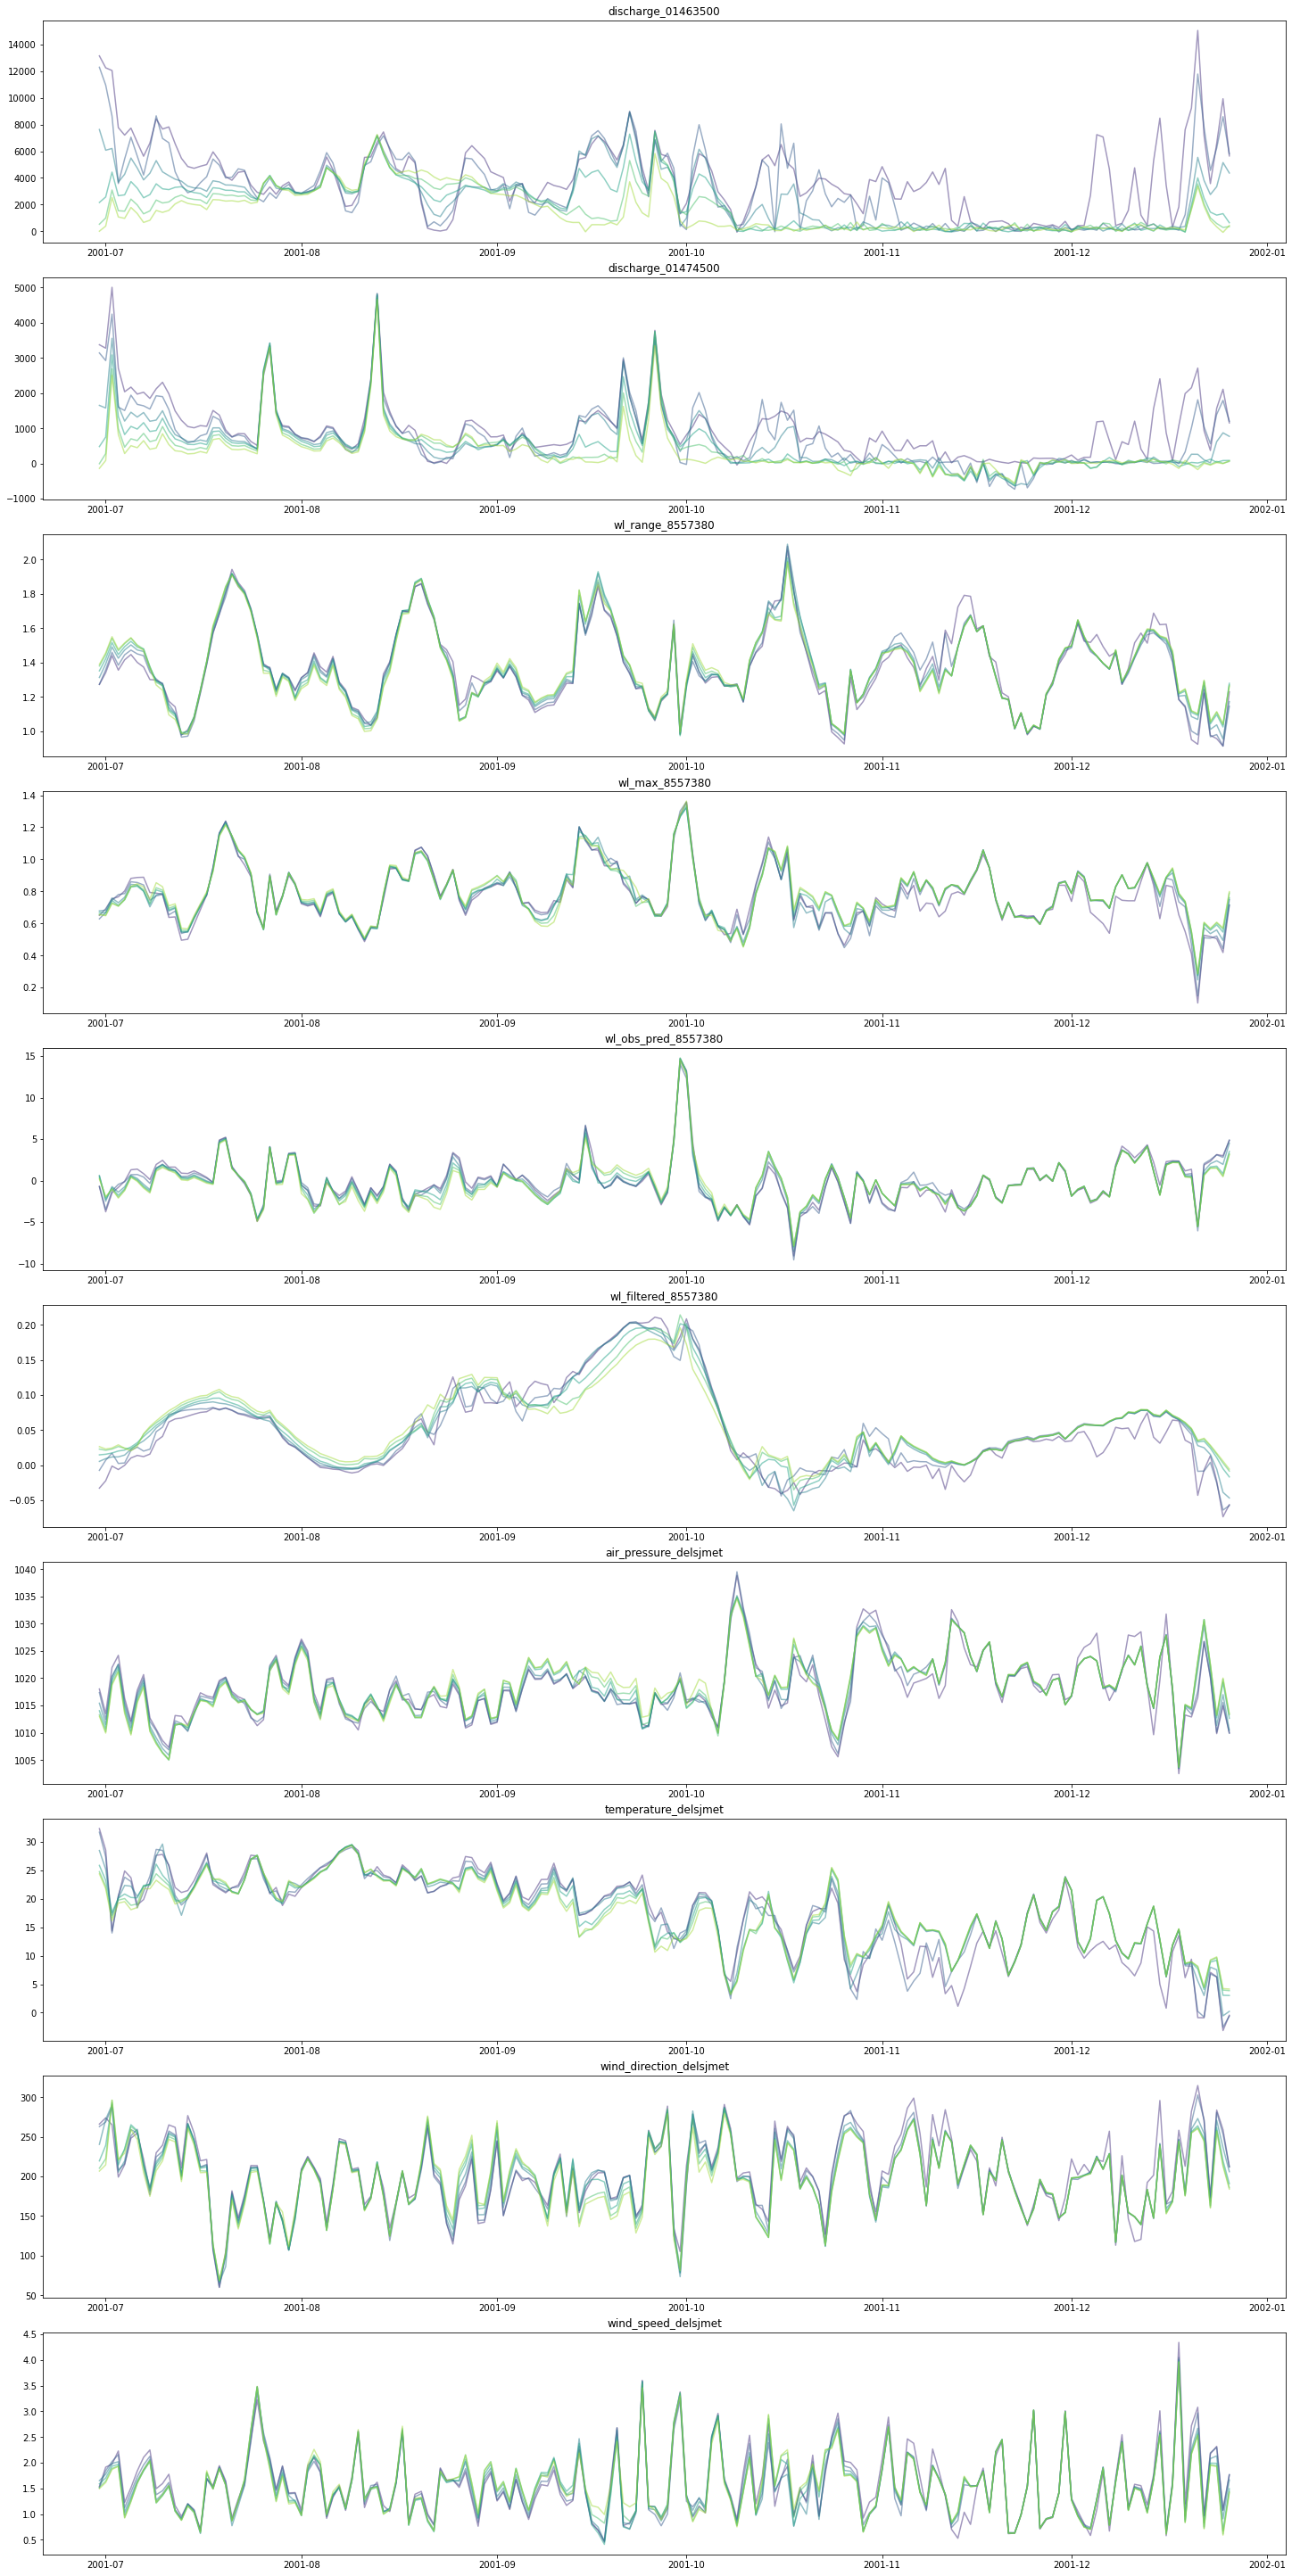

In [351]:
pal = list(sns.color_palette("viridis",len(opt_inputs)))
segs = slice(1,2)

plt.figure(figsize=(16,3))
for i in range(len(opt_inputs)):
    plt.plot(dates[segs].flatten(),y_out_scaled[i,segs].flatten(),color=pal[i],label=f'{2*i}% Increase',alpha=.5)
    plt.legend()

plt.pause(0.001)


fig, ax = plt.subplots(10,1,figsize=(20,40),constrained_layout=True)
for i in range(10):
    ax[i].set_title(config['inputs'][i])
    for j in range(len(inputs_scaled)):
        ax[i].plot(dates[segs].flatten(),inputs_scaled[j,segs,:,i].flatten(),label = f'{j}% Inflation',color=pal[j], alpha=.5)
        
                


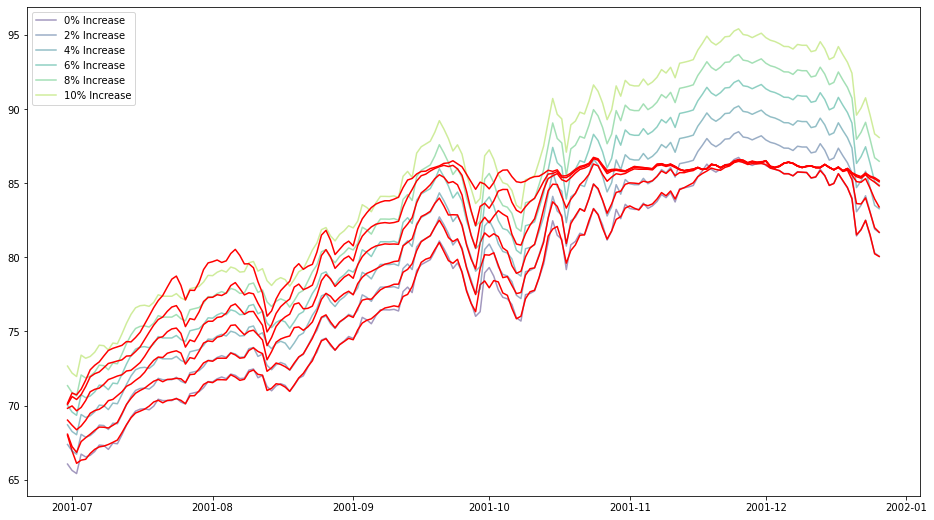

In [352]:
pal = list(sns.color_palette("viridis",len(opt_inputs)))
segs = slice(1,2)

plt.figure(figsize=(16,9))
for i in range(len(y_out_scaled)):
    plt.plot(dates[segs].flatten(),y_out_scaled[i,segs].flatten(),color=pal[i],label=f'{2*i}% Increase',alpha=.5)
    plt.plot(dates[segs].flatten(), outputs_scaled[i,segs].flatten(),color='red')
    plt.legend()

### Lets try it the other way, reducing values and seeing how much flow needs to change

In [50]:
y_mean = prepped_model_io_data['means_stds']['y_mean_trnval']['saltfront_daily'].data
y_std = prepped_model_io_data['means_stds']['y_std_trnval']['saltfront_daily'].data
tq_mean = prepped_model_io_data['means_stds']['x_mean_trnval']['discharge_01463500'].data
tq_sd = prepped_model_io_data['means_stds']['x_std_trnval']['discharge_01463500'].data
tq_mean_s = prepped_model_io_data['means_stds']['x_mean_trnval']['discharge_01474500'].data
tq_sd_s = prepped_model_io_data['means_stds']['x_std_trnval']['discharge_01474500'].data

front_q_exceedance = np.argwhere((y_original.detach().numpy() > 82.9)&(tq_original.detach().numpy()<3000))
front_exceedance = np.argwhere(y_original.detach().numpy() > 82.9)

target_series=slice(1,2)
y_deflated = ((y.clone()*y_std)+y_mean)[target_series]
reduction_zone = np.argwhere(y_deflated.detach().numpy() > 82.9)

y_deflated = torch.where(y_deflated>82.9,y_deflated, y_deflated*.99)


In [373]:
def adjust_front(x_set, y_set, target_series, start, stop, step, noise=False):
    loss_fn = rmse_masked
    inputs_out = []
    output_out = []
    y_out= []
    y_deflated = ((y_set.clone()*y_std)+y_mean)[target_series]
    
    for i in range(5):
        
        y_deflated = torch.where(y_deflated>82.9, y_deflated*0.99, y_deflated)
        y_deflated = (y_deflated-y_mean)/y_std
        optimal_input = x_set[target_series].clone()
        if noise:
            optimal_input = optimal_input + torch.empty(optimal_input.shape).normal_(mean=0,std=noise)
        optimal_input.requires_grad = True
        optimizer = torch.optim.Adam([optimal_input], lr = 0.01)
        
        m = torch.nn.ReLU()
        loss_ls=[]
        
        for i in range(50):

            optimal_output,_ = model(optimal_input)
            loss = (loss_fn(y_deflated[:,30:,:], optimal_output[:,30:,:]) + 
                    #Penalize discharge for going below zero
                    .01*torch.mean(torch.sqrt(m(torch.negative((optimal_input[:,:,0]*torch.tensor(tq_sd))+torch.tensor(tq_mean)-2500)))) +
                    .01*torch.mean(torch.sqrt(m(torch.negative((optimal_input[:,:,1]*torch.tensor(sq_sd))+torch.tensor(sq_mean))))))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_ls.append(loss.item())
        
        plt.plot(loss_ls)
        opt_out,_=model(optimal_input)
        y_out.append(y_deflated.detach().numpy())
        output_out.append(opt_out.detach().numpy())
        inputs_out.append(optimal_input.detach().numpy())
        
        y_deflated = (y_deflated*y_std)+y_mean
        
    return {'optimal_inputs':np.array(inputs_out), 'optimal_outputs':np.array(output_out), 'y_out':np.array(y_out)}


((5, 1, 180, 10), (5, 1, 180, 1))

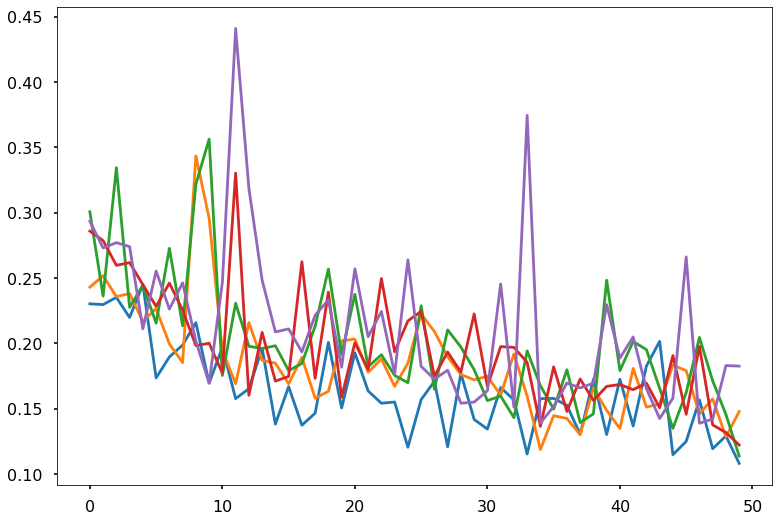

In [374]:
fronts = adjust_front(x, y, slice(1,2),0.95,1,0.01)
fronts['optimal_inputs'].shape, fronts['optimal_outputs'].shape

In [375]:
opt_inputs = fronts['optimal_inputs']
ops_outputs = fronts['optimal_outputs']
inputs_scaled = np.ones_like(opt_inputs)
actual_inputs_scaled = np.ones_like(x)
for i in range(10):
    inputs_scaled[:,:,:,i] = ((opt_inputs[:,:,:,i]*prepped_model_io_data['means_stds']['x_std_trnval'][config['inputs'][i]].data) +
                              prepped_model_io_data['means_stds']['x_mean_trnval'][config['inputs'][i]].data)

for i in range(10):
    actual_inputs_scaled[:,:,i] = ((x[:,:,i]*prepped_model_io_data['means_stds']['x_std_trnval'][config['inputs'][i]].data) +
                              prepped_model_io_data['means_stds']['x_mean_trnval'][config['inputs'][i]].data)
    
    
outputs_scaled = (ops_outputs*y_std)+y_mean
y_out_scaled = (fronts['y_out']*y_std)+y_mean

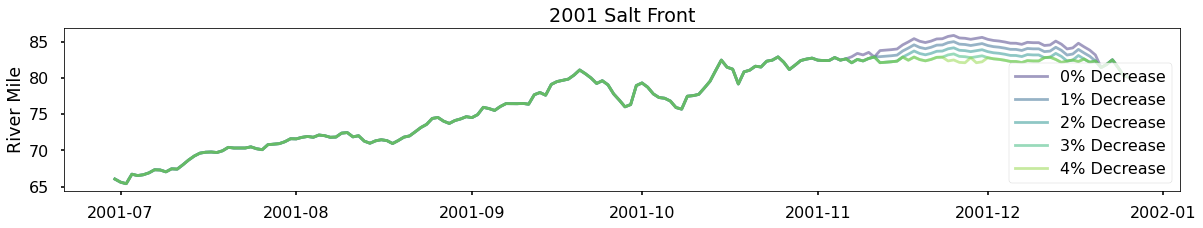

In [376]:
pal = list(sns.color_palette("viridis",len(opt_inputs)))
segs = slice(1,2)

plt.figure(figsize=(20,3))
for i in range(len(opt_inputs)):
    plt.plot(dates[segs].flatten(),y_out_scaled[i].flatten(),color=pal[i],label=f'{i}% Decrease',alpha=.5)
    plt.legend()
    plt.title('2001 Salt Front')
    plt.ylabel('River Mile')
                

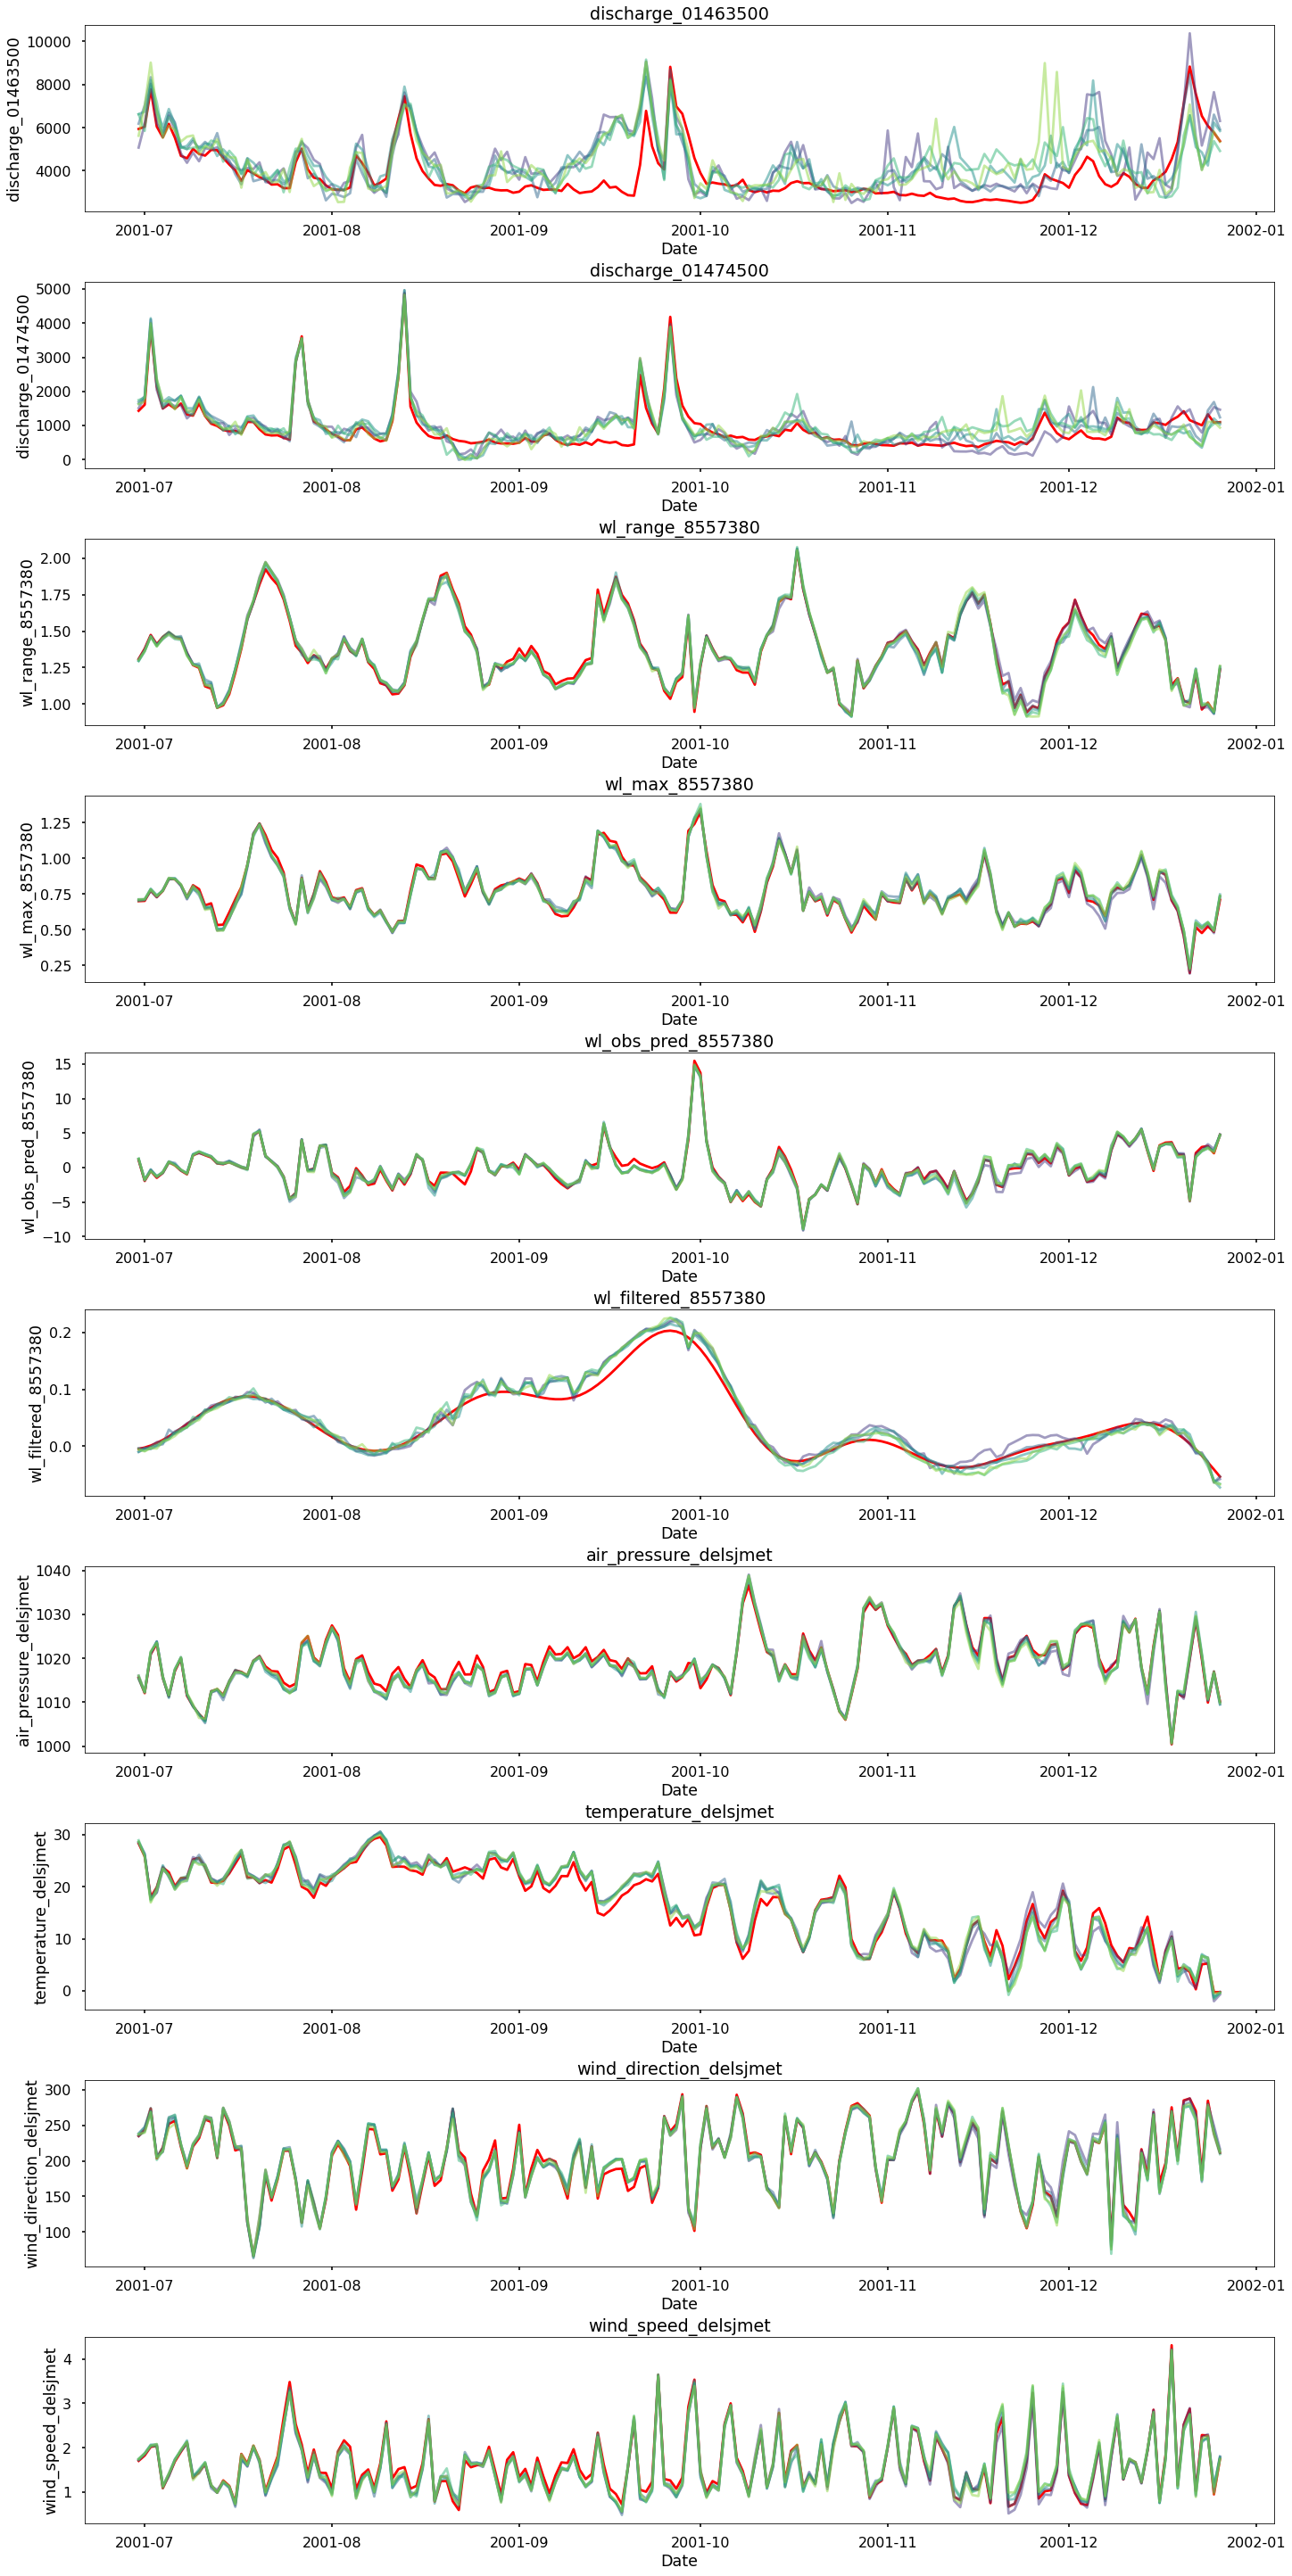

In [377]:

fig, ax = plt.subplots(10,1,figsize=(20,40),constrained_layout=True)
for i in range(10):
    ax[i].set_title(config['inputs'][i])
    ax[i].plot(dates[segs].flatten(),actual_inputs_scaled[1,:,i].flatten(),color='red',label='Observed')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel(config['inputs'][i])
    for j in range(len(inputs_scaled)):
        ax[i].plot(dates[segs].flatten(),inputs_scaled[j,:,:,i].flatten(),label = f'{j}% Decrease',color=pal[j], alpha=.5)
        


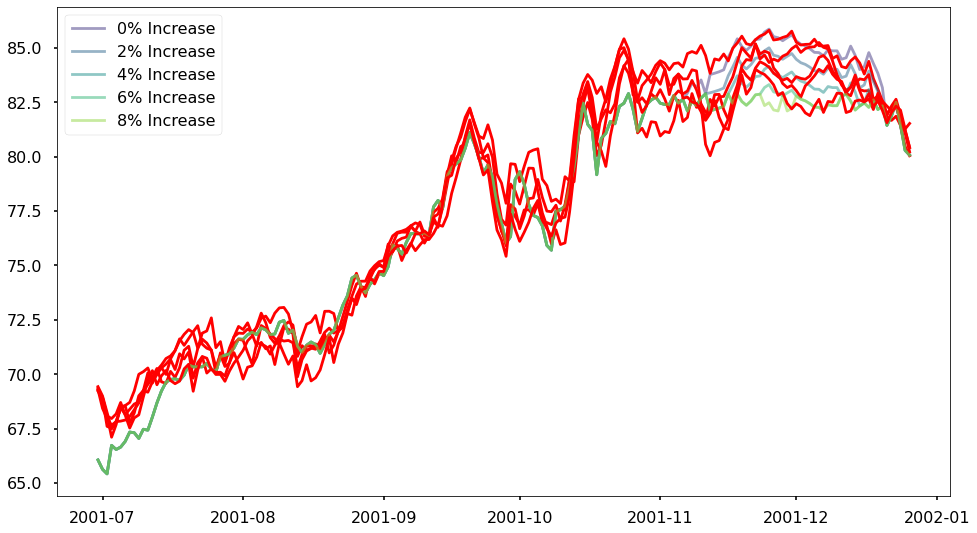

In [378]:
pal = list(sns.color_palette("viridis",len(opt_inputs)))

plt.figure(figsize=(16,9))
for i in range(len(y_out_scaled)):
    plt.plot(dates[segs].flatten(),y_out_scaled[i].flatten(),color=pal[i],label=f'{2*i}% Increase',alpha=.5)
    plt.plot(dates[segs].flatten(), outputs_scaled[i].flatten(),color='red')
    plt.legend()

In [371]:
import datetime as dt
np.argwhere(dates>np.datetime64('2001-12-01'))

array([[  1, 155,   0],
       [  1, 156,   0],
       [  1, 157,   0],
       ...,
       [ 29, 177,   0],
       [ 29, 178,   0],
       [ 29, 179,   0]])

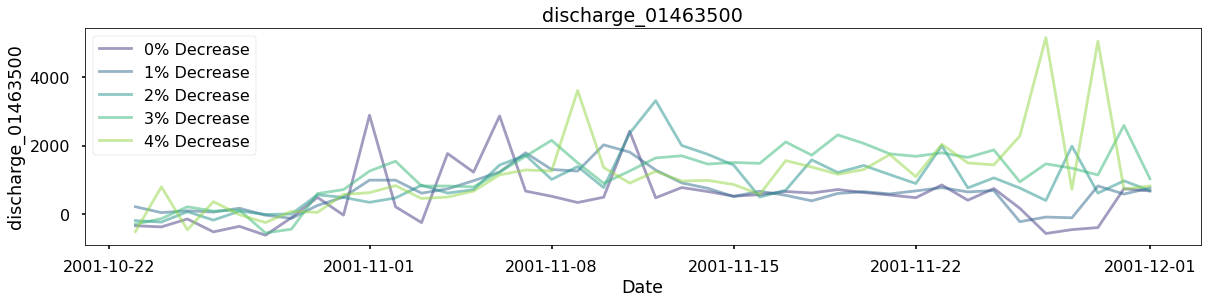

In [382]:
plt.figure(figsize=(20,4))
plt.title(config['inputs'][0])
#plt.plot(dates[segs].flatten(),actual_inputs_scaled[1,:,i].flatten(),color='red',label='Observed')
plt.xlabel('Date')
plt.ylabel(config['inputs'][0])
for j in range(len(inputs_scaled)):
    plt.plot(dates[segs].flatten()[115:155],
             (inputs_scaled[j,:,:,0]-actual_inputs_scaled[1,:,0]).flatten()[115:155],
             label = f'{j}% Decrease',color=pal[j], alpha=.5)
plt.legend()

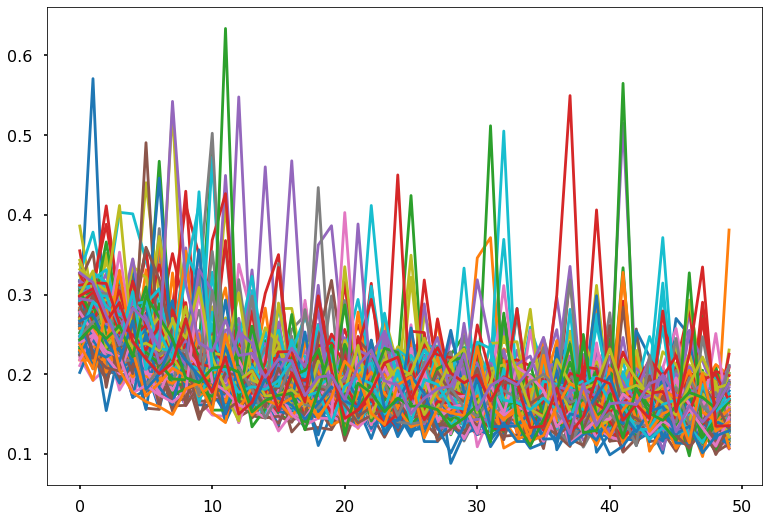

In [383]:
fronts_ensemble=[]
for i in range(25):
    fronts_run = adjust_front(x, y, slice(1,2),0.95,1,0.01)
    fronts_ensemble.append(fronts_run['optimal_inputs'])


In [384]:
ensemble_rescaled = []
for k in fronts_ensemble:
    #opt_inputs = k['optimal_inputs']
    #ops_outputs = fronts['optimal_outputs']
    inputs_scaled = np.ones_like(k)
    #actual_inputs_scaled = np.ones_like(x)
    for i in range(10):
        inputs_scaled[:,:,:,i] = ((k[:,:,:,i]*prepped_model_io_data['means_stds']['x_std_trnval'][config['inputs'][i]].data) +
                                  prepped_model_io_data['means_stds']['x_mean_trnval'][config['inputs'][i]].data)

    ensemble_rescaled.append(inputs_scaled)

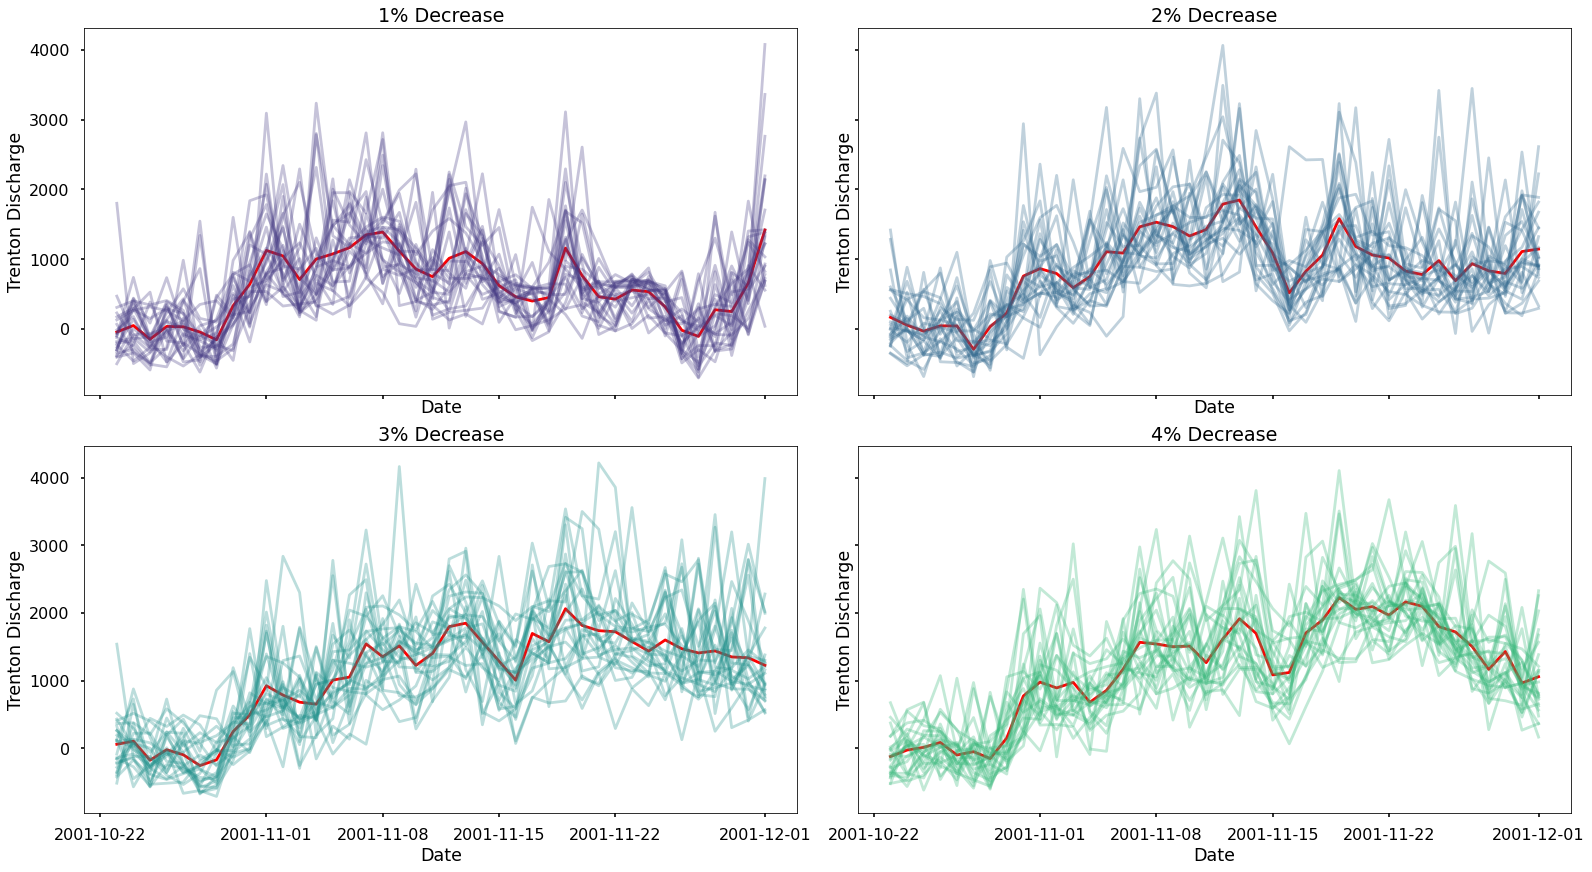

In [386]:
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(2,2,figsize=(22,12),constrained_layout=True, sharey='row',sharex='col')
for i in range(4):
    ax.ravel()[i].set_title(f'{i+1}% Decrease')
    #ax[i].plot(dates[segs][115:155].flatten(),actual_inputs_scaled[1,:,i].flatten(),color='red',label='Observed')
    ax.ravel()[i].set_xlabel('Date')
    ax.ravel()[i].set_ylabel('Trenton Discharge')
    median = (np.array(ensemble_rescaled)[:,i+1,:,115:155,0].mean(axis=0)-actual_inputs_scaled[1,115:155,0]).flatten()
    ax.ravel()[i].plot(dates[segs].flatten()[115:155],median,color='red')
    for j in range(len(ensemble_rescaled)):
        ax.ravel()[i].plot(dates[segs].flatten()[115:155],
                   (ensemble_rescaled[j][i+1,:,115:155,0]-actual_inputs_scaled[1,115:155,0]).flatten(), 
                   color=pal[i], alpha=.3)
        


(5, 1, 180, 10)